In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 13:00 - loss: 0.2133 - STD: 1.4754e-04 - MAE: 0.4524

 11/735 [..............................] - ETA: 3s - loss: 0.0431 - STD: 1.7876e-04 - MAE: 0.1584   

 20/735 [..............................] - ETA: 4s - loss: 0.0345 - STD: 1.0641e-04 - MAE: 0.1430

 29/735 [>.............................] - ETA: 4s - loss: 0.0274 - STD: 8.2799e-05 - MAE: 0.1236

 36/735 [>.............................] - ETA: 4s - loss: 0.0242 - STD: 7.1963e-05 - MAE: 0.1169

 44/735 [>.............................] - ETA: 4s - loss: 0.0215 - STD: 6.1210e-05 - MAE: 0.1096

 53/735 [=>............................] - ETA: 4s - loss: 0.0195 - STD: 5.2208e-05 - MAE: 0.1035

 62/735 [=>............................] - ETA: 4s - loss: 0.0180 - STD: 4.5953e-05 - MAE: 0.0996

 71/735 [=>............................] - ETA: 4s - loss: 0.0169 - STD: 4.1324e-05 - MAE: 0.0965

 80/735 [==>...........................] - ETA: 4s - loss: 0.0160 - STD: 3.7712e-05 - MAE: 0.0941

 89/735 [==>...........................] - ETA: 3s - loss: 0.0153 - STD: 3.5115e-05 - MAE: 0.0922

 98/735 [===>..........................] - ETA: 3s - loss: 0.0148 - STD: 3.3145e-05 - MAE: 0.0907

107/735 [===>..........................] - ETA: 3s - loss: 0.0143 - STD: 3.1595e-05 - MAE: 0.0894

116/735 [===>..........................] - ETA: 3s - loss: 0.0139 - STD: 3.0464e-05 - MAE: 0.0884

125/735 [====>.........................] - ETA: 3s - loss: 0.0136 - STD: 2.9724e-05 - MAE: 0.0875

134/735 [====>.........................] - ETA: 3s - loss: 0.0133 - STD: 2.9226e-05 - MAE: 0.0868

143/735 [====>.........................] - ETA: 3s - loss: 0.0131 - STD: 2.8987e-05 - MAE: 0.0861

152/735 [=====>........................] - ETA: 3s - loss: 0.0129 - STD: 2.8940e-05 - MAE: 0.0855

161/735 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 2.9121e-05 - MAE: 0.0850

169/735 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 2.9509e-05 - MAE: 0.0845

177/735 [======>.......................] - ETA: 3s - loss: 0.0123 - STD: 3.0241e-05 - MAE: 0.0841

186/735 [======>.......................] - ETA: 3s - loss: 0.0122 - STD: 3.1328e-05 - MAE: 0.0836

195/735 [======>.......................] - ETA: 3s - loss: 0.0120 - STD: 3.2917e-05 - MAE: 0.0832

204/735 [=======>......................] - ETA: 3s - loss: 0.0119 - STD: 3.4954e-05 - MAE: 0.0829

213/735 [=======>......................] - ETA: 3s - loss: 0.0118 - STD: 3.7644e-05 - MAE: 0.0826

222/735 [========>.....................] - ETA: 3s - loss: 0.0117 - STD: 4.0986e-05 - MAE: 0.0823

230/735 [========>.....................] - ETA: 3s - loss: 0.0116 - STD: 4.4777e-05 - MAE: 0.0820

238/735 [========>.....................] - ETA: 3s - loss: 0.0115 - STD: 4.9461e-05 - MAE: 0.0818

247/735 [=========>....................] - ETA: 2s - loss: 0.0114 - STD: 5.6190e-05 - MAE: 0.0816

256/735 [=========>....................] - ETA: 2s - loss: 0.0114 - STD: 6.5031e-05 - MAE: 0.0813

265/735 [=========>....................] - ETA: 2s - loss: 0.0113 - STD: 7.7019e-05 - MAE: 0.0811

274/735 [==========>...................] - ETA: 2s - loss: 0.0112 - STD: 9.3737e-05 - MAE: 0.0809

282/735 [==========>...................] - ETA: 2s - loss: 0.0112 - STD: 1.1448e-04 - MAE: 0.0808

288/735 [==========>...................] - ETA: 2s - loss: 0.0111 - STD: 1.3525e-04 - MAE: 0.0807

297/735 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 1.7846e-04 - MAE: 0.0805

306/735 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 2.4170e-04 - MAE: 0.0803

315/735 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 3.3895e-04 - MAE: 0.0802

324/735 [============>.................] - ETA: 2s - loss: 0.0109 - STD: 4.8527e-04 - MAE: 0.0800

333/735 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 7.0515e-04 - MAE: 0.0798

342/735 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.0010 - MAE: 0.0796    

351/735 [=============>................] - ETA: 2s - loss: 0.0107 - STD: 0.0015 - MAE: 0.0793

359/735 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 0.0020 - MAE: 0.0791

368/735 [==============>...............] - ETA: 2s - loss: 0.0105 - STD: 0.0028 - MAE: 0.0788

377/735 [==============>...............] - ETA: 2s - loss: 0.0104 - STD: 0.0036 - MAE: 0.0785

385/735 [==============>...............] - ETA: 2s - loss: 0.0104 - STD: 0.0044 - MAE: 0.0781

394/735 [===============>..............] - ETA: 2s - loss: 0.0103 - STD: 0.0053 - MAE: 0.0778

403/735 [===============>..............] - ETA: 2s - loss: 0.0102 - STD: 0.0063 - MAE: 0.0774

412/735 [===============>..............] - ETA: 1s - loss: 0.0101 - STD: 0.0073 - MAE: 0.0771

421/735 [================>.............] - ETA: 1s - loss: 0.0100 - STD: 0.0082 - MAE: 0.0767

430/735 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 0.0092 - MAE: 0.0763

439/735 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0101 - MAE: 0.0759

448/735 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0111 - MAE: 0.0755

457/735 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0120 - MAE: 0.0751

466/735 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0129 - MAE: 0.0748

475/735 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0138 - MAE: 0.0744

484/735 [==================>...........] - ETA: 1s - loss: 0.0094 - STD: 0.0146 - MAE: 0.0740

493/735 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 0.0154 - MAE: 0.0737

502/735 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 0.0162 - MAE: 0.0734

511/735 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0170 - MAE: 0.0731

520/735 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0177 - MAE: 0.0727

529/735 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0184 - MAE: 0.0724

538/735 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.0192 - MAE: 0.0721

547/735 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.0199 - MAE: 0.0718

556/735 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.0206 - MAE: 0.0715

565/735 [======================>.......] - ETA: 1s - loss: 0.0088 - STD: 0.0213 - MAE: 0.0713

574/735 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0219 - MAE: 0.0710

583/735 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0225 - MAE: 0.0707

591/735 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0231 - MAE: 0.0704

600/735 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0237 - MAE: 0.0702

607/735 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0241 - MAE: 0.0700

616/735 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.0247 - MAE: 0.0697

625/735 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0253 - MAE: 0.0695

633/735 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0258 - MAE: 0.0693

641/735 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0262 - MAE: 0.0691

650/735 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0267 - MAE: 0.0689

659/735 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0272 - MAE: 0.0687

668/735 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0277 - MAE: 0.0684

677/735 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0282 - MAE: 0.0682

686/735 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0286 - MAE: 0.0680

694/735 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0291 - MAE: 0.0679

703/735 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0295 - MAE: 0.0677

712/735 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.0300 - MAE: 0.0675

716/735 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.0302 - MAE: 0.0674

727/735 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0307 - MAE: 0.0671

735/735 [==============================] - 7s 8ms/step - loss: 0.0079 - STD: 0.0311 - MAE: 0.0670 - val_loss: 0.0042 - val_STD: 0.0504 - val_MAE: 0.0512


Epoch 2/10000


  1/735 [..............................] - ETA: 21s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0506

  9/735 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518 

 18/735 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0514

 26/735 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0517

 34/735 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0513

 42/735 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0513

 50/735 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0514

 58/735 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0515

 67/735 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0515

 76/735 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0515

 85/735 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

 94/735 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0515

103/735 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

110/735 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

119/735 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

128/735 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

137/735 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

146/735 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

154/735 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0515

162/735 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

171/735 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

180/735 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

189/735 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

198/735 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

207/735 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0513

215/735 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0513

223/735 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0513

231/735 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0513

240/735 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

249/735 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0512

257/735 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0512

266/735 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0512

275/735 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0511

284/735 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0511

293/735 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

300/735 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

309/735 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0510

318/735 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0510

327/735 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

335/735 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

344/735 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

353/735 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

362/735 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

371/735 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

380/735 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

389/735 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

397/735 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

405/735 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

413/735 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

422/735 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

431/735 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

439/735 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

447/735 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

456/735 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

465/735 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

474/735 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

483/735 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0505

492/735 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0505

501/735 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0505

509/735 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0505

516/735 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0505

524/735 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0504

533/735 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0504

542/735 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0504

551/735 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0504

560/735 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0504

569/735 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0503

578/735 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

587/735 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

596/735 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

605/735 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

614/735 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

623/735 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

632/735 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

641/735 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

650/735 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

659/735 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

668/735 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

677/735 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

686/735 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

695/735 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500

704/735 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500

713/735 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0499

721/735 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500

729/735 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0500

735/735 [==============================] - 5s 7ms/step - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500 - val_loss: 0.0035 - val_STD: 0.0493 - val_MAE: 0.0430


Epoch 3/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0040 - STD: 0.0685 - MAE: 0.0460

  9/735 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0688 - MAE: 0.0476 

 18/735 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0479

 27/735 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

 36/735 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

 45/735 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0478

 54/735 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0480

 63/735 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

 72/735 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

 81/735 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

 90/735 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

 99/735 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0478

108/735 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

117/735 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0478

126/735 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0477

135/735 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0477

144/735 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0477

153/735 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

162/735 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

171/735 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0477

180/735 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0477

187/735 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0477

196/735 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

205/735 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

214/735 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0476

223/735 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0476

231/735 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0475

240/735 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0475

249/735 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

258/735 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

267/735 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

276/735 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

285/735 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

294/735 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

303/735 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

312/735 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

321/735 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

330/735 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

339/735 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

348/735 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

357/735 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

366/735 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

375/735 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

384/735 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

393/735 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

402/735 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

410/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

419/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

428/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

437/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

446/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

455/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

464/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

473/735 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

482/735 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

491/735 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

500/735 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

509/735 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

518/735 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

527/735 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

536/735 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

545/735 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

554/735 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

563/735 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

572/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

581/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

590/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

599/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

608/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

617/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

626/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

635/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

644/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

653/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

662/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

670/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

679/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

687/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

696/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

705/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

714/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

723/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

732/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

735/735 [==============================] - 5s 6ms/step - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468 - val_loss: 0.0031 - val_STD: 0.0565 - val_MAE: 0.0412


Epoch 4/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0458

  8/735 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0463 

 16/735 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

 25/735 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

 34/735 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

 43/735 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

 52/735 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

 61/735 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

 70/735 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

 79/735 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

 88/735 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

 96/735 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

105/735 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

114/735 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

123/735 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

131/735 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

140/735 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

147/735 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

156/735 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

165/735 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

173/735 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

181/735 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

190/735 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

199/735 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

207/735 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

215/735 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

224/735 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

233/735 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

242/735 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

251/735 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

259/735 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

268/735 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

277/735 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

285/735 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

293/735 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

302/735 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

311/735 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

319/735 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

327/735 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

336/735 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

345/735 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

354/735 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

363/735 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

370/735 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

379/735 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

387/735 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

396/735 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

405/735 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

414/735 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

423/735 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

432/735 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

441/735 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

450/735 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

458/735 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

467/735 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

475/735 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

483/735 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

492/735 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

501/735 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

510/735 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

519/735 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

528/735 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

537/735 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

546/735 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

555/735 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

563/735 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

572/735 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

580/735 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

589/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

597/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

605/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

613/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

622/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

630/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

639/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

648/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

657/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

666/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

675/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

684/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

692/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

701/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

709/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

718/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

727/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

735/735 [==============================] - 5s 7ms/step - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449 - val_loss: 0.0032 - val_STD: 0.0584 - val_MAE: 0.0417


Epoch 5/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0437

  6/735 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430 

 14/735 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 22/735 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

 31/735 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

 40/735 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

 48/735 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

 57/735 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

 65/735 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

 74/735 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

 83/735 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

 92/735 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

101/735 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

108/735 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

117/735 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

125/735 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

133/735 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

141/735 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

150/735 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

159/735 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

168/735 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

177/735 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

186/735 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

195/735 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

204/735 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

211/735 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

219/735 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

228/735 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

237/735 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

246/735 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

254/735 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

263/735 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

271/735 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

279/735 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

288/735 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

297/735 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

304/735 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

313/735 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

321/735 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

329/735 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

337/735 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

345/735 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

353/735 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

361/735 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

370/735 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

378/735 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

386/735 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

395/735 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

403/735 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

412/735 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

421/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

430/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

439/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

448/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

457/735 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

466/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

475/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

484/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

493/735 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

500/735 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

506/735 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

512/735 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

518/735 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

523/735 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

528/735 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

536/735 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

544/735 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

553/735 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

562/735 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

571/735 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

579/735 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

587/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

596/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

605/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

614/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

623/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

632/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

641/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

650/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

659/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

668/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

677/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

686/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

695/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

704/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

713/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

722/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

731/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

735/735 [==============================] - 5s 7ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0567 - val_MAE: 0.0408


Epoch 6/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0028 - STD: 0.0747 - MAE: 0.0403

  8/735 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431 

 18/735 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

 27/735 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0436

 36/735 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

 45/735 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

 54/735 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

 63/735 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

 72/735 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 81/735 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 90/735 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 98/735 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

106/735 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

114/735 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

123/735 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

132/735 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

141/735 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

150/735 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

159/735 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

168/735 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

177/735 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

186/735 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

193/735 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

201/735 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

207/735 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

216/735 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

225/735 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

234/735 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

243/735 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

252/735 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

261/735 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

270/735 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

279/735 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

287/735 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

296/735 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

305/735 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

314/735 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

323/735 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

332/735 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

341/735 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

350/735 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

359/735 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

368/735 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

375/735 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

382/735 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

390/735 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

398/735 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

406/735 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

415/735 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

424/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

433/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

442/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

451/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

460/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

469/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

478/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

487/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

496/735 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

505/735 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

513/735 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

522/735 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

530/735 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

538/735 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

547/735 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

556/735 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

565/735 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

574/735 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

583/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

591/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

600/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

609/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

618/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

627/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

636/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

645/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

654/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

663/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

672/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

680/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

689/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

698/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

707/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

716/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

725/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

734/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

735/735 [==============================] - 5s 7ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0615 - val_MAE: 0.0404


Epoch 7/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0420

 10/735 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0424 

 19/735 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0420

 28/735 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0757 - MAE: 0.0417

 37/735 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0417

 46/735 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

 55/735 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

 64/735 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

 73/735 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 82/735 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 90/735 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 99/735 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

108/735 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

117/735 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

126/735 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

135/735 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

144/735 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

153/735 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

162/735 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

171/735 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

180/735 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

189/735 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

198/735 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

207/735 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

216/735 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

225/735 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

234/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

242/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

251/735 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

260/735 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

269/735 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

278/735 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

287/735 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

296/735 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

305/735 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

314/735 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

323/735 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

329/735 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

337/735 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

346/735 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

355/735 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

363/735 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

372/735 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

381/735 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

389/735 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

397/735 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

406/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

415/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

424/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

432/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

440/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

449/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

458/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

467/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

476/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

485/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

493/735 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

502/735 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

511/735 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

520/735 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

528/735 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

537/735 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

546/735 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

555/735 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

564/735 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

573/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

582/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

589/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

597/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

607/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

615/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

624/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

632/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

640/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

649/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

658/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

667/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

676/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

685/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

694/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

703/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

712/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

720/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

728/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

735/735 [==============================] - 5s 7ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0612 - val_MAE: 0.0393


Epoch 8/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0401

  9/735 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0761 - MAE: 0.0408 

 16/735 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

 24/735 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 32/735 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 40/735 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 48/735 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

 55/735 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 62/735 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 70/735 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 78/735 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 86/735 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

 94/735 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

102/735 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

109/735 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

117/735 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

124/735 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

132/735 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

140/735 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

148/735 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

154/735 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

162/735 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

170/735 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

177/735 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

185/735 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

193/735 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

202/735 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

211/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

219/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

227/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

235/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

243/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

252/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

260/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

267/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

275/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

283/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

290/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

298/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

306/735 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

313/735 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

321/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

329/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

337/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

344/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

351/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

359/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

367/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

374/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

382/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

390/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

398/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

405/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

412/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

420/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

428/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

436/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

444/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

451/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

459/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

467/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

475/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

483/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

490/735 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

497/735 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

504/735 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

512/735 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

520/735 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

527/735 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

535/735 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

543/735 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

551/735 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

559/735 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

566/735 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

573/735 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

581/735 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

589/735 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

597/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

604/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

612/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

619/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

627/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

634/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

641/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

649/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

656/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

664/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

672/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

679/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

686/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

694/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

701/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

709/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

717/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

725/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

733/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

735/735 [==============================] - 5s 7ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0627 - val_MAE: 0.0393


Epoch 9/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0392

  9/735 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0397 

 17/735 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 24/735 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0402

 31/735 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

 38/735 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

 46/735 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0408

 55/735 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

 64/735 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

 72/735 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

 80/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

 88/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

 95/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

103/735 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

111/735 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

119/735 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

127/735 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

135/735 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

142/735 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

149/735 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

156/735 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

163/735 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

170/735 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

175/735 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

181/735 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

187/735 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

193/735 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

200/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

207/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

214/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

221/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

227/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

232/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

238/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

245/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

252/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

258/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

264/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

271/735 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

277/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

283/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

290/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

297/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

304/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

310/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

316/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

323/735 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

331/735 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

338/735 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

346/735 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

354/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

362/735 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

370/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

377/735 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

384/735 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

392/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

400/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

407/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

415/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

423/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

431/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

438/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

446/735 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

454/735 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

462/735 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

469/735 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

476/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

484/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

491/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

498/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

506/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

514/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

522/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

530/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

538/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

546/735 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

555/735 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

563/735 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

571/735 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

579/735 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

587/735 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

594/735 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

601/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

608/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

616/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

623/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

630/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

638/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

646/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

654/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

662/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

670/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

678/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

686/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

694/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

702/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

710/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

718/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

726/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

734/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

735/735 [==============================] - 6s 8ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0625 - val_MAE: 0.0390


Epoch 10/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0392

  8/735 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399 

 15/735 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

 21/735 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

 28/735 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

 35/735 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

 43/735 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

 50/735 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

 57/735 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0401

 64/735 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

 71/735 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

 79/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

 87/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

 94/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

101/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

108/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

115/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

122/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

129/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

136/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

144/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

152/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

160/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

167/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

174/735 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

181/735 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

189/735 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

196/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

203/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

211/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

218/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

225/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

232/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

239/735 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

246/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

253/735 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

260/735 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

267/735 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

274/735 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

281/735 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

289/735 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

296/735 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

303/735 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

311/735 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

318/735 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

326/735 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

333/735 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

341/735 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

348/735 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

356/735 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

363/735 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

370/735 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

377/735 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

385/735 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

392/735 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

399/735 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

407/735 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

414/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

421/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

428/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

436/735 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

443/735 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

450/735 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

458/735 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

465/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

472/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

479/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

486/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

493/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

501/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

508/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

515/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

522/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

529/735 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

536/735 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

543/735 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

550/735 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

557/735 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

564/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

571/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

578/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

585/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

593/735 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

600/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

607/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

615/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

622/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

629/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

636/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

643/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

651/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

658/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

666/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

673/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

680/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

687/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

694/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

701/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

709/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

716/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

723/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

731/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

735/735 [==============================] - 6s 8ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0673 - val_MAE: 0.0408


Epoch 11/10000


  1/735 [..............................] - ETA: 21s - loss: 0.0025 - STD: 0.0846 - MAE: 0.0395

  9/735 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393 

 16/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0394

 23/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0394

 30/735 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0394

 38/735 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 46/735 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 54/735 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 62/735 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 70/735 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 78/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 85/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 93/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

101/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

109/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

117/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

124/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

132/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

140/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

148/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

155/735 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0395

163/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

171/735 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

178/735 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

186/735 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

194/735 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

201/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

208/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

215/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

223/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

230/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

238/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

245/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

252/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

260/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

267/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

275/735 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

283/735 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

290/735 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

298/735 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

306/735 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

313/735 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

321/735 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

329/735 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

337/735 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

345/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

353/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

360/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

368/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

376/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

383/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

390/735 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

397/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

404/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

412/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

420/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

428/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

435/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

443/735 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

450/735 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

457/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

465/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

473/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

481/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

488/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

496/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

504/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

511/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

519/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

527/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

535/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

543/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

550/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

557/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

564/735 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

571/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

577/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

585/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

592/735 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

599/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

607/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

614/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

620/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

627/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

635/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

642/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

649/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

657/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

665/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

673/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

680/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

687/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

695/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

703/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

710/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

718/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

725/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

732/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

735/735 [==============================] - 6s 8ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394 - val_loss: 0.0029 - val_STD: 0.0622 - val_MAE: 0.0390


Epoch 12/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0027 - STD: 0.0774 - MAE: 0.0372

  9/735 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0384 

 17/735 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

 24/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 32/735 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

 40/735 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

 47/735 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 55/735 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

 63/735 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 70/735 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 78/735 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

 86/735 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

 93/735 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

101/735 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

109/735 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

116/735 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

124/735 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

131/735 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

138/735 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

145/735 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

152/735 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

159/735 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

166/735 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

174/735 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

181/735 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

188/735 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

195/735 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

203/735 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

211/735 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

219/735 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

227/735 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

235/735 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

242/735 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

250/735 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

257/735 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

263/735 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

270/735 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

278/735 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

285/735 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

293/735 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

301/735 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

309/735 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

316/735 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

323/735 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

331/735 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

338/735 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

346/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

353/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

360/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

367/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

374/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

382/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

390/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

397/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

404/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

411/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

418/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

425/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

432/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

439/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

446/735 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

453/735 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

461/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

469/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

477/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

484/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

492/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

500/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

507/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

515/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

522/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

529/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

536/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

543/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

551/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

559/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

567/735 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

574/735 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

581/735 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

588/735 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

595/735 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

603/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

611/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

619/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

627/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

634/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

642/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

649/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

656/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

664/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

671/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

678/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

685/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

693/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

701/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

708/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

715/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

722/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

729/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

735/735 [==============================] - 6s 8ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389 - val_loss: 0.0029 - val_STD: 0.0624 - val_MAE: 0.0390


Epoch 13/10000


  1/735 [..............................] - ETA: 21s - loss: 0.0028 - STD: 0.0774 - MAE: 0.0377

  7/735 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0389 

 14/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

 21/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0387

 28/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0386

 35/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0384

 43/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

 51/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

 58/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

 66/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

 74/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

 81/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

 89/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

 96/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

103/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

111/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

118/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

125/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

132/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

139/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

146/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

153/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

160/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

168/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

175/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

182/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

188/735 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

196/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

204/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

212/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

219/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

226/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

234/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

241/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

248/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

256/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

264/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

272/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

279/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

286/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

294/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

301/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

308/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

315/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

322/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

330/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

337/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

345/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

353/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

360/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

367/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

374/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

382/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

389/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

396/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

403/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

410/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

418/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

425/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

432/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

438/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

444/735 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

451/735 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

458/735 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

465/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

472/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

479/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

486/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

494/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

502/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

509/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

517/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

523/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

529/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

536/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

543/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

550/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

557/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

564/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

571/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

578/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

585/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

592/735 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

598/735 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

605/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

611/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

617/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

625/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

633/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

640/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

647/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

654/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

662/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

669/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

677/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

684/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

691/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

698/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

705/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

712/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

720/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

728/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

735/735 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

735/735 [==============================] - 6s 8ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383 - val_loss: 0.0028 - val_STD: 0.0639 - val_MAE: 0.0388


Epoch 14/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0025 - STD: 0.0799 - MAE: 0.0367

  8/735 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0786 - MAE: 0.0380 

 15/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0380

 21/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0379

 28/735 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

 35/735 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

 42/735 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

 49/735 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0380

 57/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

 64/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

 72/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

 80/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

 87/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

 95/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

102/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

110/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

117/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

125/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

133/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0380

141/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

149/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

156/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

164/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

172/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

180/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

188/735 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

196/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

203/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

211/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

218/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

226/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

234/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

242/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

249/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

255/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

261/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

268/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

274/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

282/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

290/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

297/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

305/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

312/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

320/735 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

328/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0380

336/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0379

343/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0379

350/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0379

357/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

364/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

371/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

378/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

385/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

393/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

401/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

409/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

417/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

425/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

432/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

440/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

448/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

456/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

464/735 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

471/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

478/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

485/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

491/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

498/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

505/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

513/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

521/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

527/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

534/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

542/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

549/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

557/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

564/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

572/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

580/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

588/735 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

595/735 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

602/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

610/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

617/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

625/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

633/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

641/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

649/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

657/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

665/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

673/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

680/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

687/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

694/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

701/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

709/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

716/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

723/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

730/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

735/735 [==============================] - 6s 8ms/step - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377 - val_loss: 0.0031 - val_STD: 0.0617 - val_MAE: 0.0403


Epoch 15/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0026 - STD: 0.0790 - MAE: 0.0366

  8/735 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369 

 15/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

 23/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0822 - MAE: 0.0376

 30/735 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0375

 38/735 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0374

 45/735 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0372

 52/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

 59/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

 67/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

 75/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

 82/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

 89/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

 96/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

103/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

111/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

118/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

125/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

133/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

140/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0372

148/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

155/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

163/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

170/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

177/735 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

184/735 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

191/735 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

198/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

205/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

213/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

220/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

228/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

235/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0375

243/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

251/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

258/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

265/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

273/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

280/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

287/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

294/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

301/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

308/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

315/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

322/735 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

328/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

335/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

342/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

349/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

356/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

363/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

370/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

377/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

384/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

391/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

398/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

405/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

411/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

418/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

425/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

432/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

439/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

447/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

455/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

462/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

469/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

476/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

484/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

491/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

499/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

507/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

515/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

523/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

531/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

538/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

545/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

552/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

560/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

568/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

576/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

584/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

592/735 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

600/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

608/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

616/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

624/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

631/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

639/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

646/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

654/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

662/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

670/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

678/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

686/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

693/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

701/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

709/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

717/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

724/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

731/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

735/735 [==============================] - 6s 8ms/step - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374 - val_loss: 0.0029 - val_STD: 0.0651 - val_MAE: 0.0390


Epoch 16/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0022 - STD: 0.0785 - MAE: 0.0345

  9/735 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360 

 17/735 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0365

 25/735 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0365

 33/735 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

 41/735 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

 49/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 56/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

 64/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

 72/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0366

 80/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

 88/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

 95/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

102/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

110/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

117/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

124/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

131/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

139/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

147/735 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

155/735 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

163/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

171/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

178/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

186/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

194/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

202/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

210/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

218/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0370

225/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0370

233/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0370

241/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0370

248/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

256/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

264/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

272/735 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0370

280/735 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

287/735 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

295/735 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

303/735 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

311/735 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

319/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

327/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

335/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

342/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

349/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

357/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

365/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

373/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

381/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

389/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

397/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

405/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

412/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

420/735 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

428/735 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

436/735 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

444/735 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

452/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

460/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

468/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

476/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

484/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

492/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

500/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

508/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

516/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

524/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

532/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

540/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

548/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

556/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

564/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

572/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

580/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

588/735 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

596/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

604/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

612/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

620/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

628/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

636/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

644/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

652/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

660/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

668/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

675/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

683/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

690/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

698/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

706/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

714/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

722/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

730/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

735/735 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369 - val_loss: 0.0030 - val_STD: 0.0639 - val_MAE: 0.0404


Epoch 17/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0369

  8/735 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366 

 15/735 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

 22/735 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

 30/735 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

 37/735 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

 45/735 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

 52/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

 59/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

 67/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

 74/735 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

 81/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

 89/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

 96/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

104/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

112/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

119/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

127/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

135/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

142/735 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

150/735 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

157/735 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

164/735 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

171/735 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

179/735 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

187/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

195/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

202/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

210/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

217/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

225/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

233/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

240/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

247/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

254/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

261/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

269/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

277/735 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

284/735 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

291/735 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

298/735 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

305/735 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

313/735 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

321/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

328/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

335/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

341/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

348/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

355/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

362/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

369/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

377/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

384/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

391/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

398/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

405/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

412/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

419/735 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

426/735 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

434/735 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

442/735 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

449/735 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

456/735 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

464/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

471/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

478/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

485/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

492/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

499/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

506/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

513/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

520/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

527/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

535/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

542/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

549/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

557/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

564/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

571/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

578/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

586/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

595/735 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

603/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

610/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

618/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

626/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

634/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

642/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

649/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

656/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

663/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

671/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

678/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

685/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

693/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

700/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

707/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

714/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

721/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0366

728/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

735/735 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

735/735 [==============================] - 6s 8ms/step - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365 - val_loss: 0.0035 - val_STD: 0.0714 - val_MAE: 0.0454


Epoch 18/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0034 - STD: 0.0902 - MAE: 0.0458

  8/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0377 

 15/735 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0369

 22/735 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0364

 30/735 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

 38/735 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

 45/735 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

 53/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0359

 60/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0359

 67/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

 74/735 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

 82/735 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

 90/735 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0361

 97/735 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

104/735 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

112/735 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

119/735 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

127/735 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

135/735 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

143/735 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

151/735 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

159/735 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

167/735 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

174/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

180/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

187/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

195/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

202/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

209/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

217/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

224/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

232/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

240/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

247/735 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

254/735 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

261/735 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

268/735 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

275/735 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

283/735 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

290/735 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

297/735 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

304/735 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

311/735 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

318/735 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

325/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

332/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

340/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

347/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

355/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

363/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

370/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

378/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

386/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

394/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

402/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

410/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

418/735 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

425/735 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

432/735 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

439/735 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

446/735 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

454/735 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

462/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

470/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

478/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

485/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

493/735 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

501/735 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

509/735 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

517/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

525/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

533/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

541/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

549/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

556/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

564/735 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

571/735 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

579/735 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

587/735 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

594/735 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

602/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

610/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

618/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

626/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

634/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

641/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

648/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

655/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

663/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

671/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

679/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

686/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

694/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

702/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

710/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

718/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

725/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

732/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

735/735 [==============================] - 6s 8ms/step - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359 - val_loss: 0.0029 - val_STD: 0.0646 - val_MAE: 0.0391


Epoch 19/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0021 - STD: 0.0765 - MAE: 0.0340

  8/735 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0834 - MAE: 0.0357 

 16/735 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0838 - MAE: 0.0359

 23/735 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0836 - MAE: 0.0358

 31/735 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0834 - MAE: 0.0358

 38/735 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0357

 45/735 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0837 - MAE: 0.0356

 52/735 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0838 - MAE: 0.0356

 60/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0835 - MAE: 0.0355

 67/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0836 - MAE: 0.0355

 75/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0836 - MAE: 0.0355

 83/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0354

 91/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0353

 98/735 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

106/735 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0353

114/735 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

122/735 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

130/735 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

138/735 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

145/735 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0355

152/735 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0355

159/735 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0355

166/735 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

174/735 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

181/735 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

188/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

195/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

202/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

210/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

217/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

225/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

233/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

241/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

248/735 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

256/735 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

263/735 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

271/735 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

278/735 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

285/735 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

293/735 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

300/735 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

308/735 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

315/735 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

322/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

330/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

337/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

345/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

352/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

360/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

368/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

376/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

383/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

391/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

398/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

405/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

413/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

420/735 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

428/735 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

435/735 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

443/735 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

450/735 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

457/735 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

465/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

473/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

481/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

488/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

496/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

504/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

511/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

519/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

526/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

533/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

540/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

547/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

555/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

563/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

571/735 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

578/735 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

585/735 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

592/735 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

599/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

606/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

613/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

620/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

627/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

634/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

641/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

648/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

655/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

662/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

670/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

677/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

684/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

691/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

698/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

705/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

713/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

720/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

727/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

734/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

735/735 [==============================] - 6s 8ms/step - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353 - val_loss: 0.0031 - val_STD: 0.0638 - val_MAE: 0.0401


Epoch 20/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0022 - STD: 0.0783 - MAE: 0.0338

  8/735 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0353 

 15/735 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0353

 23/735 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

 31/735 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0354

 38/735 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

 45/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

 52/735 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

 59/735 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0352

 66/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

 73/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0352

 80/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

 88/735 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0351

 96/735 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0351

104/735 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0350

111/735 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0351

118/735 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0351

125/735 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0350

133/735 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0351

141/735 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0350

148/735 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0350

155/735 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0350

162/735 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0350

169/735 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0350

176/735 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0350

184/735 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0350

192/735 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0350

200/735 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0350

208/735 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

215/735 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

223/735 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

230/735 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

237/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

244/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

251/735 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

259/735 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

266/735 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

274/735 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

282/735 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

290/735 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0350

298/735 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0350

306/735 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

314/735 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

322/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

330/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

338/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

346/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

354/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

361/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

368/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

376/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

384/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

392/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

400/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

407/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

415/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

423/735 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

431/735 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

439/735 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

447/735 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

455/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

463/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

471/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

479/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

487/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

495/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

503/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

511/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

519/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

527/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

535/735 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

543/735 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

550/735 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

558/735 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

566/735 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

573/735 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

580/735 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

587/735 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

595/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

604/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

611/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

618/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

626/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

634/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

641/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

649/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

657/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

665/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

672/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

679/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

687/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

695/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

702/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

709/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

717/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

724/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

731/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

735/735 [==============================] - 6s 8ms/step - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351 - val_loss: 0.0031 - val_STD: 0.0682 - val_MAE: 0.0417


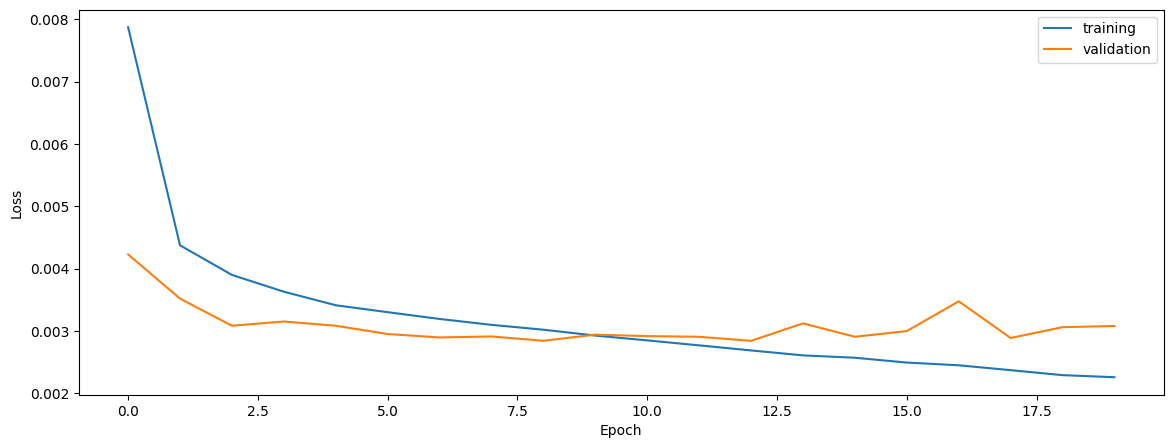

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8486333493331031
0.8232664877320296
0.8033561126539357


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8486333493331031
0.8232664877320296
0.8033561126539357


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8480574786024612
0.8225093838380337
0.8019784207968945


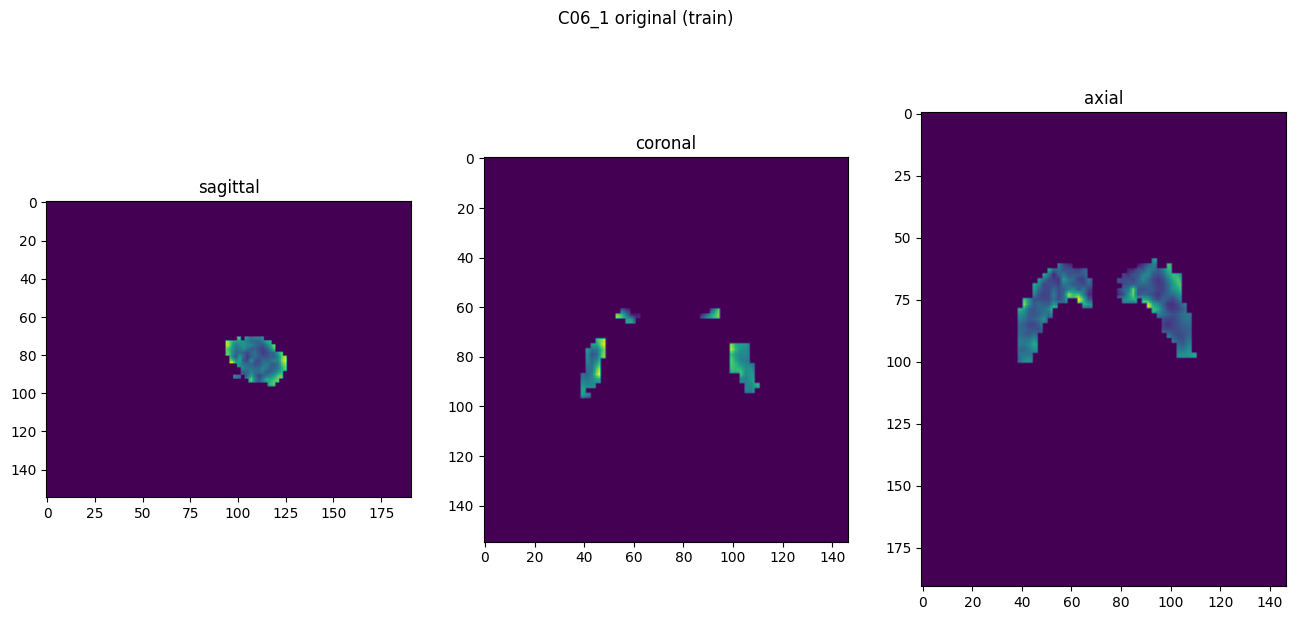

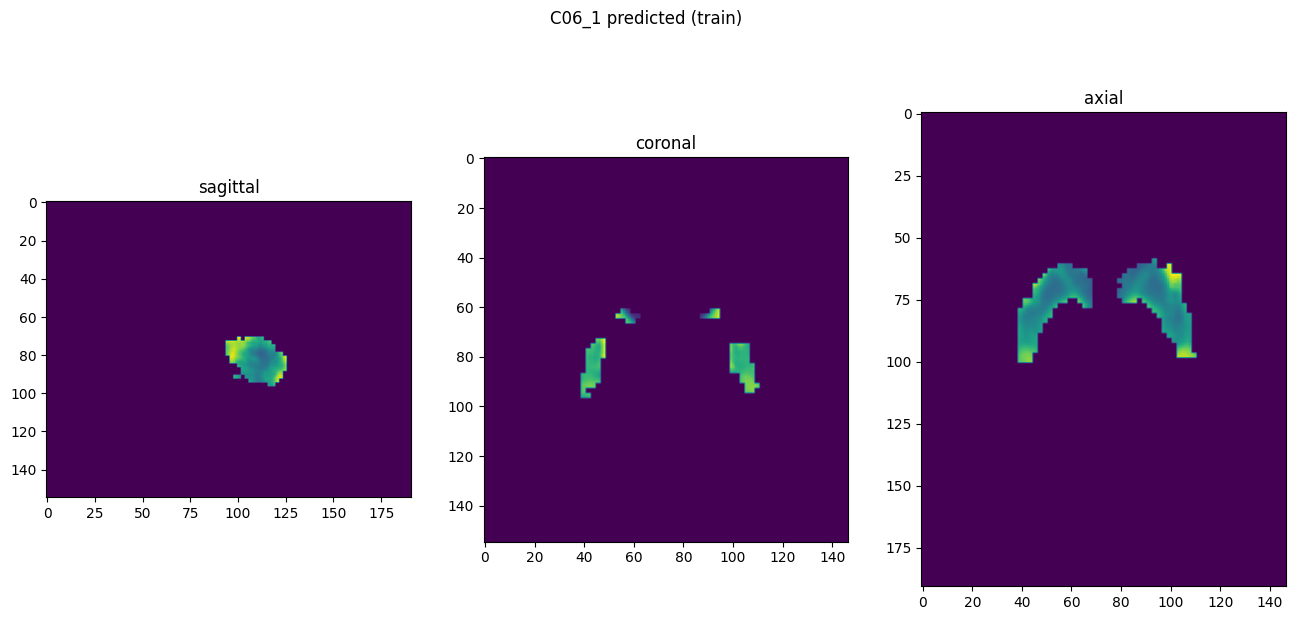

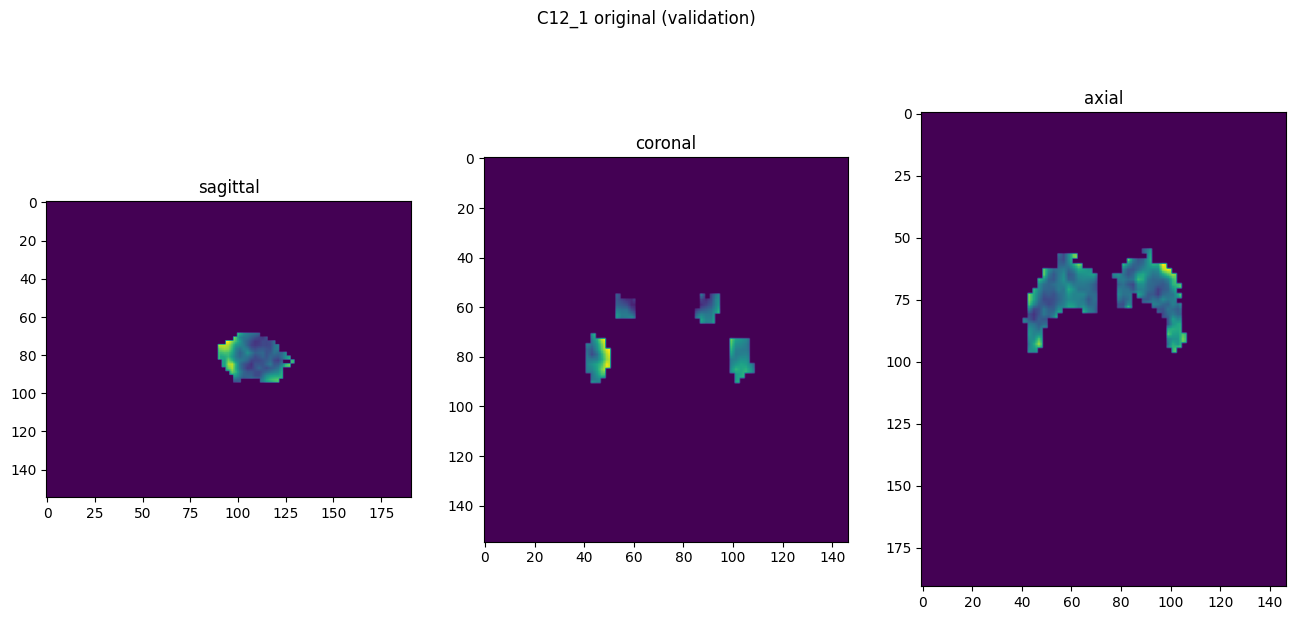

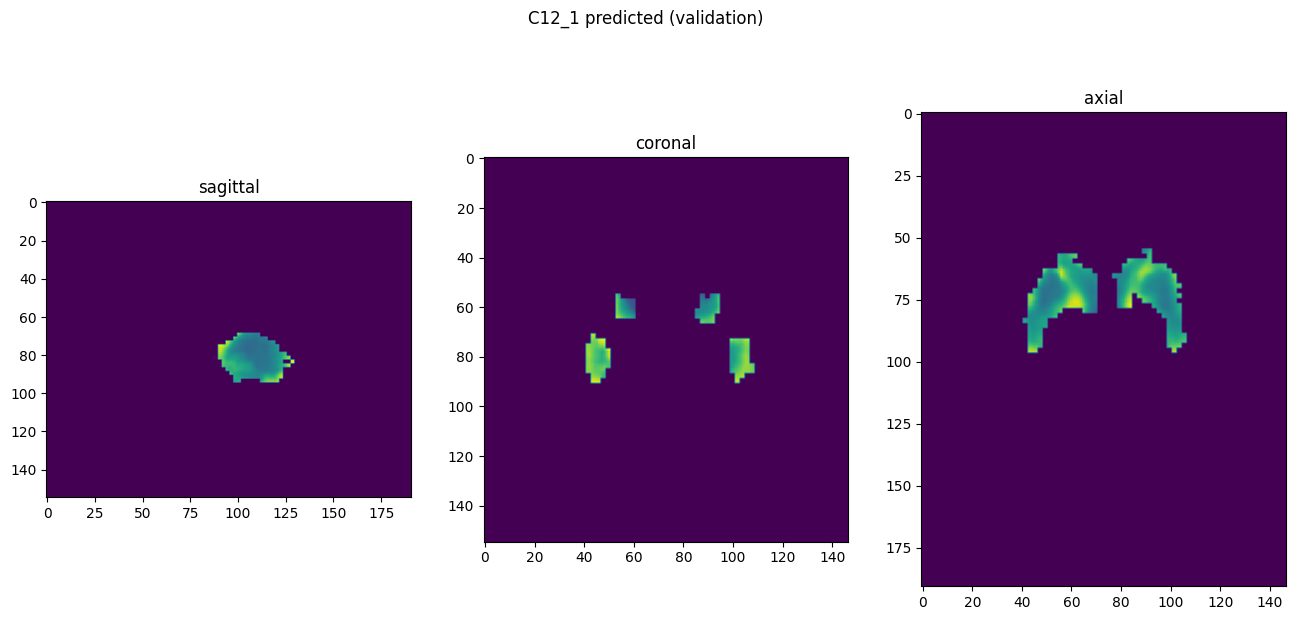

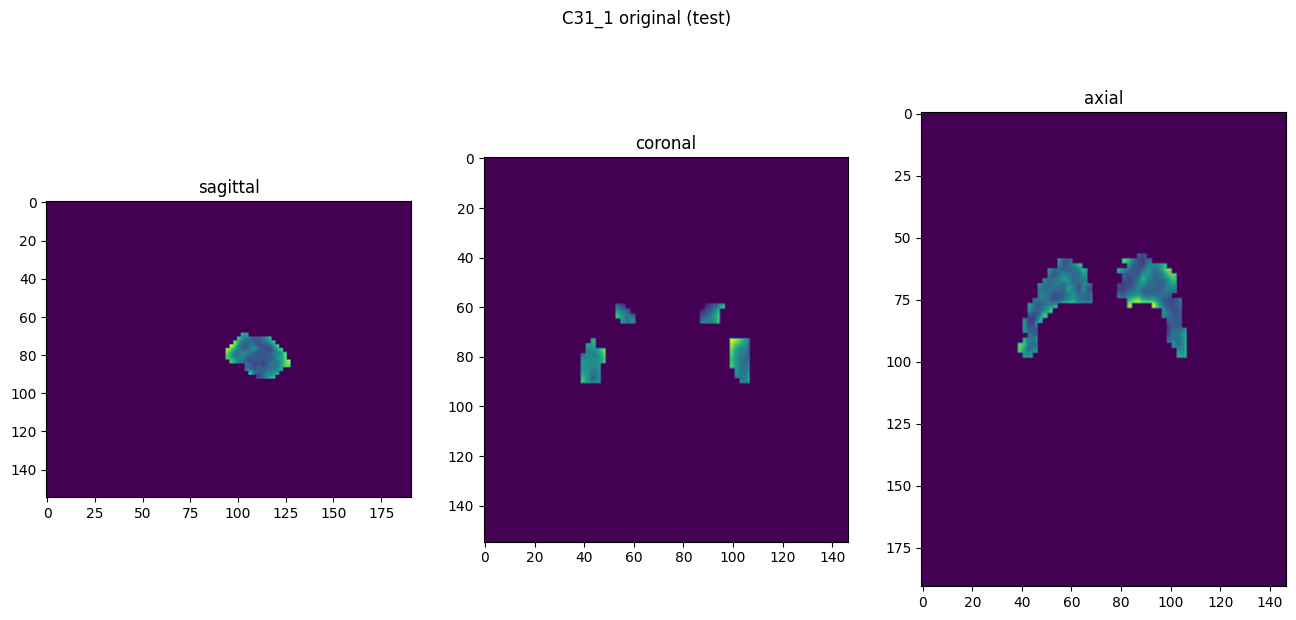

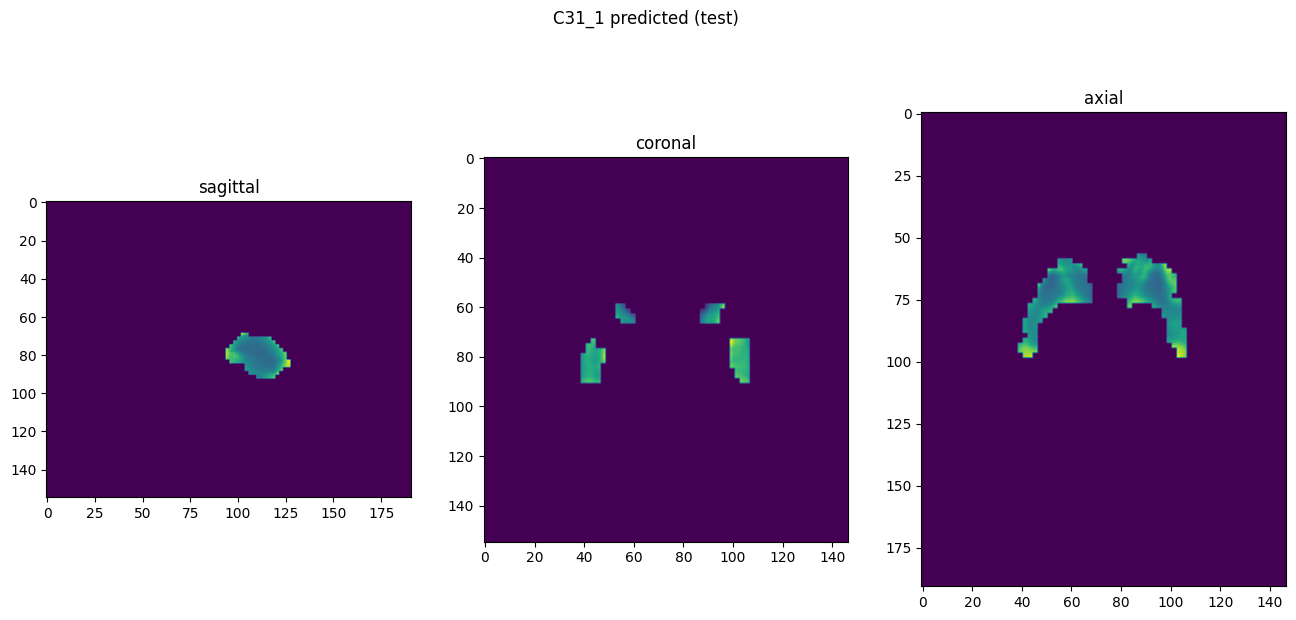

In [10]:
showResults(model, gen, threshold=None, background=False)